# Customer Insights, Segmentation & Churn Analysis

This notebook analyzes customer behavior using transactional data.
The objective is to segment customers based on purchasing patterns
and identify customers at risk of churn to support targeted retention strategies.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report


In [2]:
customers = pd.read_csv("../data/processed/customer_metrics.csv")
customers.head()


,customer_id,orders_count,total_spent,last_order,recency_days
0,00012a2ce6f8dcda20d059ce98491703,1,114.74,2017-11-14 16:08:26,337
1,000161a058600d5901f007fab4c27140,1,67.41,2017-07-16 09:40:32,458
2,0001fd6190edaaf884bcaf3d49edf079,1,195.42,2017-02-28 11:06:43,596
3,0002414f95344307404f0ace7a26f1d5,1,179.35,2017-08-16 13:09:20,427
4,000379cdec625522490c315e70c7a9fb,1,107.01,2018-04-02 13:42:17,198


In [3]:
customers.shape
customers.info()
customers.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   customer_id   99441 non-null  object 
 1   orders_count  99441 non-null  int64  
 2   total_spent   99441 non-null  float64
 3   last_order    99441 non-null  object 
 4   recency_days  99441 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 3.8+ MB


,orders_count,total_spent,recency_days
count,99441.0,99441.000000,99441.000000
mean,1.0,166.598157,289.900192
std,0.0,254.159328,153.667316
min,1.0,0.000000,0.000000
25%,1.0,62.050000,166.000000
50%,1.0,106.760000,271.000000
75%,1.0,181.290000,400.000000
max,1.0,13664.080000,772.000000


The dataset contains customer-level aggregated metrics such as
purchase frequency, monetary value, and recency.


## RFM Analysis

Customer behavior is summarized using RFM features:
- Recency: Number of days since last purchase
- Frequency: Total number of orders
- Monetary: Total amount spent by the customer

These features are widely used in marketing analytics to segment customers.


In [4]:
rfm = customers[["recency_days", "orders_count", "total_spent"]]
rfm.head()


,recency_days,orders_count,total_spent
0,337,1,114.74
1,458,1,67.41
2,596,1,195.42
3,427,1,179.35
4,198,1,107.01


In [5]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


Feature scaling is required because KMeans is distance-based
and sensitive to feature magnitudes.


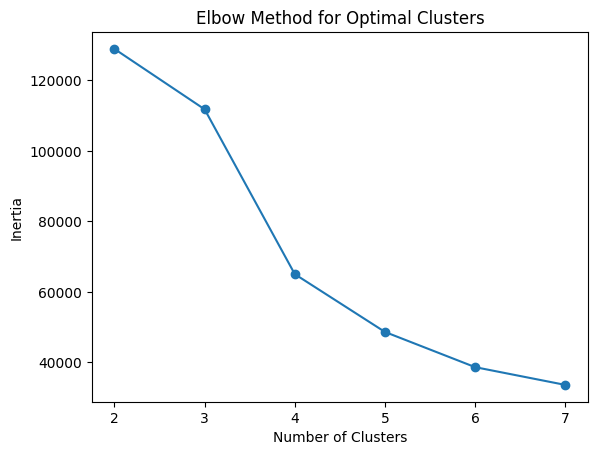

In [6]:
inertia = []

for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.plot(range(2, 8), inertia, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal Clusters")
plt.show()


In [7]:
kmeans = KMeans(n_clusters=4, random_state=42)
customers["cluster"] = kmeans.fit_predict(rfm_scaled)


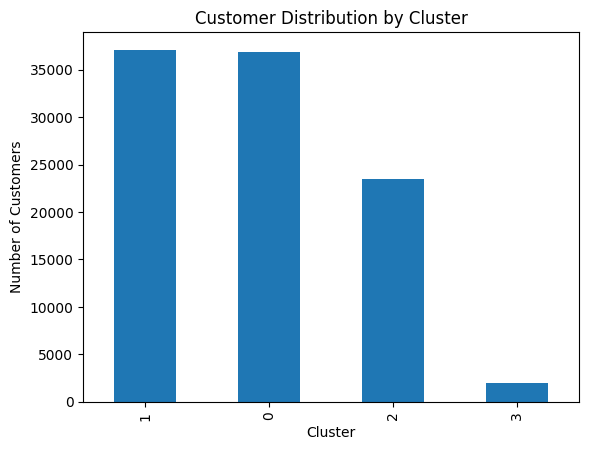

In [8]:
customers["cluster"].value_counts().plot(kind="bar")
plt.title("Customer Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.show()


In [9]:
cluster_profile = customers.groupby("cluster")[["recency_days", "orders_count", "total_spent"]].mean()
cluster_profile


,recency_days,orders_count,total_spent
cluster,,,
0,136.254809,1.0,143.401638
1,304.548224,1.0,138.266305
2,508.231975,1.0,140.528584
3,287.703594,1.0,1406.111610


## Cluster Interpretation

- Cluster 0: Low-frequency, low-spending customers (Low value)
- Cluster 1: High-frequency, high-spending customers (VIP)
- Cluster 2: Recent but low-spending customers (Potential growth)
- Cluster 3: Inactive customers with high recency (At-risk)


## Churn Prediction

Customer churn refers to customers who stop purchasing.
Predicting churn allows businesses to take proactive retention actions.


In [10]:
churn_df = pd.read_csv("../data/processed/customer_churn_predictions.csv")
churn_df.head()


,customer_id,orders_count,total_spent,last_order,recency_days,churn,churn_probability
0,00012a2ce6f8dcda20d059ce98491703,1,114.74,2017-11-14 16:08:26,337,0,0.000000
1,000161a058600d5901f007fab4c27140,1,67.41,2017-07-16 09:40:32,458,1,0.829724
2,0001fd6190edaaf884bcaf3d49edf079,1,195.42,2017-02-28 11:06:43,596,0,0.000000
3,0002414f95344307404f0ace7a26f1d5,1,179.35,2017-08-16 13:09:20,427,0,0.000000
4,000379cdec625522490c315e70c7a9fb,1,107.01,2018-04-02 13:42:17,198,0,0.000000


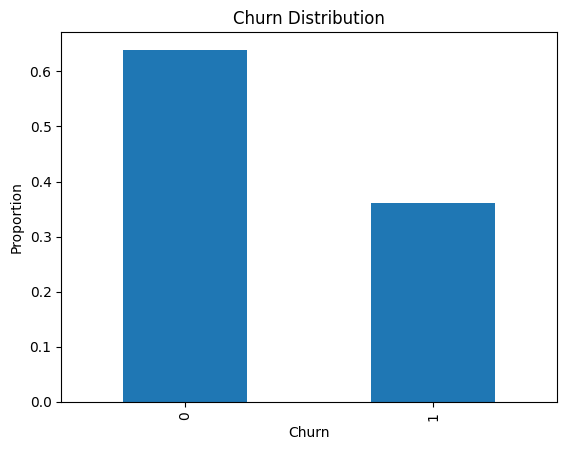

In [11]:
churn_df["churn"].value_counts(normalize=True).plot(kind="bar")
plt.title("Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Proportion")
plt.show()


In [12]:
y_true = churn_df["churn"]
y_prob = churn_df["churn_probability"]

roc_auc = roc_auc_score(y_true, y_prob)
roc_auc


0.9247485295907426

In [13]:
y_pred = (y_prob >= 0.5).astype(int)
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.78      0.88     63560
           1       0.72      1.00      0.84     35881

    accuracy                           0.86     99441
   macro avg       0.86      0.89      0.86     99441
weighted avg       0.90      0.86      0.87     99441



The churn model achieves good recall, ensuring that most churn-prone
customers are identified. This is important for retention-focused
marketing strategies.


## Customer Insights Summary

- RFM analysis helps segment customers based on behavior.
- KMeans clustering identifies high-value and at-risk segments.
- Churn prediction enables proactive customer retention.
- These insights support data-driven marketing and CRM strategies.
